# Deep Learning: Week 6
# Convolutional Neural Networks (ConvNets)

__Content creators:__ Konrad Kording, Hmrishav Bandyopadhyay

__Content reviewers:__  

---
# Tutorial Objectives
TBA

# Question of the week
TBA

[answers ]

# Recap the experience from last week

Tell us your thoughts about what you have learned



In [ ]:
# report to Airtable

---
# Getting Started

## Setup


In [ ]:
#@title Dependencies
!pip install livelossplot --quiet



In [ ]:
#@title Imports
#%matplotlib notebook
import os
import cv2
from tqdm.auto import tqdm
# Imports
import time
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

#@title String fields


# Device_Type= 'cuda' #@param ["cuda", "cpu"]

# dev=torch.device(Device_Type)
# temp=torch.rand(1).to(dev)
# del temp

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cuda'), 1)

In [ ]:
# @title Utils
%%capture


"""

Taken from 
https://github.com/snatch59/load-cifar-10/blob/master/load_cifar_10.py

"""

def sobel(img,ret_gray=False):

    
    # sobelX = np.array((
	# [-1, 0, 1],
	# [-2, 0, 2],
	# [-1, 0, 1]), dtype="int")
    # sobelY = np.array((
	# [-1,-2,-1],
	# [ 0, 0, 0],
	# [ 1, 2, 1]), dtype="int")

    if len(img.shape)!=2:
        if img.shape[0]==3:
            raise NotImplementedError
        if img.shape[2]==3:
            #img = np.float32(img)
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray=img.copy()
   
    #grad_x= cv2.filter2D(gray,-1, cv2.flip(sobelX, -1), borderType=cv2.BORDER_CONSTANT)
    
    ddepth=cv2.CV_16S
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3)#, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3)#, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    if ret_gray:
        return grad,gray
    else:
        return grad

def canny(img,ret_gray=False):
    
    if len(img.shape)!=2:
        if img.shape[0]==3:
            raise NotImplementedError
        if img.shape[2]==3:
            #img = np.float32(img)
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray=img.copy()
   
    

    edge= cv2.Canny(img,100,200)
    if ret_gray:
        return edge,gray
    else:
        return edge


def unpickle_cifar(file_name):
    with open(file_name, 'rb') as file_pick:
        import pickle
        data = pickle.load(file_pick, encoding='bytes')
    return data

def load_cifar_10_data(data_dir='cifar-10-batches-py', negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle_cifar(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle_cifar(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle_cifar(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)
    cifar_train_data=cifar_train_data.transpose(0,3,1,2)
    cifar_test_data=cifar_test_data.transpose(0,3,1,2)
    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names





## Convolutions and Parameter Sharing

The Capacity or the complexity of a neural network is determined by the number of hidden layers it has and by the number of parameters it learns. One of the many ways to prevent the network from overfitting is thus, reducing the parameter count. 

<br>
<br>


Convolutional Networks encourage weight sharing by learning a single kernel that is repeated over the entire input image. In general this kernel is barely a few parameters as compared to the huge number of parameters in a linear network. Let's calculate the parameters of a few layer network on random data using both conv layers and linear layers, which return the same output sizes.


In [ ]:
#@title Reduced_Params == Reduced_time_to_train

batch_size= 1 #@param {type:"integer"}
sample_image=torch.rand(batch_size,3,32,32)
print("Input Shape {}".format(sample_image.shape))



Num_Linears = 3 #@param {type:"slider", min:1, max:3, step:1}
linear_layer = []
for i in range(Num_Linears):
    linear_layer.append(nn.Linear(32*32*3,32*32*3,bias=False))
linear_layer = nn.Sequential(*linear_layer)

kernel_size= 3 #@param {type:"slider", min:3, max:21, step:2}

Num_Convs = 3 #@param {type:"slider", min:1, max:20, step:1}
conv_layer = []
for i in range(Num_Convs):
    conv_layer.append(nn.Conv2d(in_channels=3,out_channels=3,kernel_size=kernel_size,padding=True,bias=False))
conv_layer = nn.Sequential(*conv_layer)


t1=time.time()
print("\nOutput From Linear {}".format(linear_layer(torch.flatten(sample_image,1)).shape))
t2=time.time()
print("Output From Conv Layer {}".format(conv_layer(sample_image).shape))
t3=time.time()

#print("Time taken by Linear Layer {}".format(t2-t1))
print("\nPerformance improvement by Conv Layer {:.2f} %".format(((t2-t1)-(t3-t2))*100.0/(t2-t1)))


print("\nTotal Parameters in Linear Layer {}".format(sum(p.numel() for p in linear_layer.parameters())))
print("Total Parameters in Linear Layer {}".format(sum(p.numel() for p in conv_layer.parameters())))

del linear_layer,conv_layer

Input Shape torch.Size([1, 3, 32, 32])

Output From Linear torch.Size([1, 3072])
Output From Conv Layer torch.Size([1, 3, 32, 32])

Performance improvement by Conv Layer 63.69 %

Total Parameters in Linear Layer 28311552
Total Parameters in Linear Layer 243


The difference in parameters is huge and keeps on multiplying as the input image size increases as the linear layer tries to build a matrix that can be directly multiplied with the input pixels.

<br>

The CNN paramater size, however is invariant of the image size, as irrespective of the input that it gets, it keeps sliding the same learnable filter over the images. The reduced parameter set not only brings down memory usage by huge chunks, but also allows the model to generalize better


## Learning Edge Detection:
Edge Detection is a form of feature selection or extraction where we extract the edges of objects in the image. This can be achieved with various image processing tools, one of them being the Sobel edge detector.


$$ S_{1}=\begin{bmatrix}
    -1 & 0 & 1 \\
    -2 & 0 & 2 \\
    -1 & 0 & 1  \\
  \end{bmatrix}
  S_{2}=\begin{bmatrix}
    1 & 2 & 1 \\
     0 & 0 & 0 \\
    -1 & -2 & -1 \\
  \end{bmatrix}
$$

$S_{1}$ and $S_{2}$ are kernels designed by hand to respond maximally to horizontal and vertical edges in the image and the output from these two is averaged to get an edge map from the image. Kernels similar to these can be learned by single layer CNNs to effectively find edges in images

In [ ]:
#@title Download and Unpack Stanford Dogs Dataset (suggest smaller dataset with 256x256 Images)
%%capture
!rm -r Images
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xf images.tar
!rm -r images.tar

In [ ]:
#@title Load Data

l1=[]
ctr=0
for i in os.listdir('Images'):
    l1=l1+['./Images/'+i+"/"+l_ for l_ in os.listdir('./Images/'+i)]
    ctr+=1
    if ctr==10:
        break

k=len(l1)
train_data=np.zeros((k,3,256,256))

for i1,i in tqdm(enumerate(l1)):
    img=cv2.resize(cv2.imread(i),(256,256))
    train_data[i1,:,:,:]=img.transpose(2,0,1)


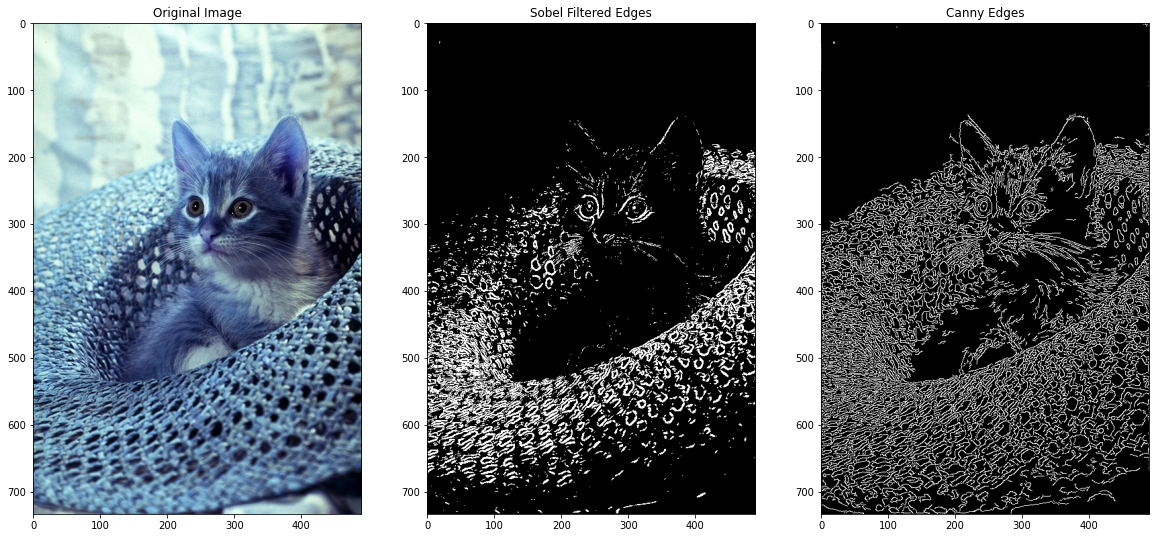

In [ ]:
#@title Sobel And Canny Edges

import cv2
import os
from IPython.utils import io
with io.capture_output() as captured:   
    os.system('rm -r cat*')
    os.system('rm -r pool*')
    os.system('wget https://homepages.cae.wisc.edu/~ece533/images/cat.png')
    os.system('wget https://homepages.cae.wisc.edu/~ece533/images/pool.png')
    



img=cv2.imread("cat.png")
f, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].set_title('Original Image')
sobeled=sobel(img)
sobeled=sobeled/255.0
sobeled[sobeled>=0.5]=1
sobeled[sobeled<0.5]=0
ax[1].imshow(sobeled,cmap='gray')
ax[1].set_title("Sobel Filtered Edges")
canny_img=canny(img)
canny_img=canny_img/255.0
ax[2].imshow(canny_img,cmap='gray')
ax[2].set_title("Canny Edges")
f.set_size_inches(20, 20)
plt.show()


In [ ]:
#@title Build the Canny Ground Truth
## Building Test set : Increase efficiency

sob_val=np.expand_dims(train_data[:,0,:,:].copy(),axis=1)
sob_train=np.expand_dims(train_data[:,0,:,:].copy(),axis=1)
from tqdm.auto import tqdm
train_data=np.float32(train_data)
train_data=np.uint8(train_data)

for i in tqdm(range(len(train_data))):
    #print(train_data.shape)
    
    o1,o2=canny(train_data[i].transpose(1,2,0),ret_gray=True)
    #print(o1.shape,o2.shape)
    sob_train[i,0,:,:]=np.expand_dims(o2,axis=0)
    sob_val[i,0,:,:]=np.expand_dims(o1,axis=0)

##Normalize
#
sob_val=sob_val/255.0

#sob_val[sob_val>=0.5]=1
#sob_val[sob_val<0.5]=0
#print(np.unique(sob_val))
#sob_train=sob_train/255.0
#print(np.unique(sob_val))

### Train a Conv Kernel



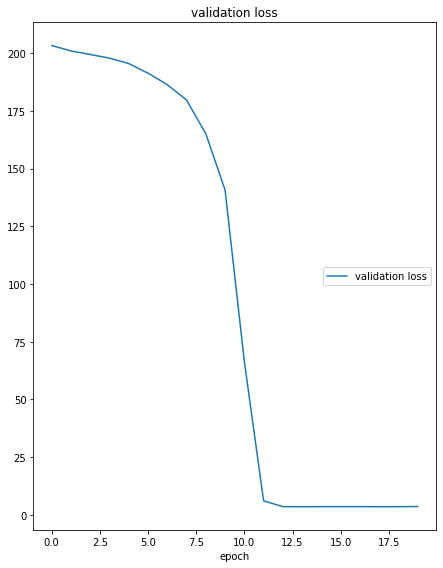

validation loss
	validation loss  	 (min:    3.499, max:  203.398, cur:    3.594)


In [ ]:
#@title Train a Conv kernel to detect edges
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1,bias=False)
        self.weights=self.conv1.to(dev).weight.transpose(2,3)
        self.sigmoid=nn.Sigmoid().to(dev)
    def forward(self,x):
        d1 = self.conv1(x)
        d2 = F.conv2d(x, self.weights,padding=1).to(dev)
        
        out = self.sigmoid((d1+d2)/2.0)
        return out
from livelossplot import PlotLosses
liveloss = PlotLosses()
model=Net().to(dev)
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9,0.999))
criterion=nn.BCELoss()
epochs=20
from torch.utils.data import TensorDataset, DataLoader

train = torch.Tensor(sob_train) 
val = torch.Tensor(sob_val)
ds = TensorDataset(train,val) 
batch_size=50
load = DataLoader(ds,batch_size=batch_size,shuffle=True)
loss_k=0
min_loss=9999999

for i in (range(epochs)):
    c=0
    loss_k=0
    logs = {}
    
    for data,label in load:
        c+=1
        optimizer.zero_grad()
        out=model(data.to(dev)).to(dev)
        
        loss=criterion(out,label.to(dev))*1e-3
        loss.backward()
        optimizer.step()
        
        loss_k+=(float(loss))*batch_size
        
    loss_k=loss_k/(len(load.dataset)//batch_size)*batch_size*1.0
    #print("Loss {}".format(float(loss_k)))
    if (loss_k)<min_loss:
        min_loss=loss_k
        torch.save(model.state_dict(),'model.pt')

    #prefix = ''
        
    
    logs['validation loss'] = loss_k
    
    
    liveloss.update(logs)
    liveloss.send()


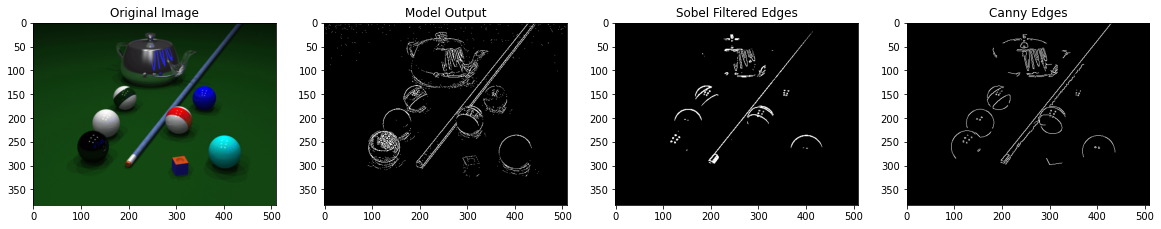

In [ ]:
#@title Check Model Outputs

model.load_state_dict(torch.load('model.pt'))
img=cv2.imread("pool.png")
f, ax = plt.subplots(1, 4)
ax[0].imshow(img)
ax[0].set_title('Original Image')

img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
data_in=torch.tensor(img).unsqueeze(0).unsqueeze(0)
grad_x=model(data_in.float().to(dev)).squeeze().detach().cpu().numpy()
grad_x=grad_x/np.max(grad_x)
grad_x[grad_x>=0.5]=1
grad_x[grad_x<0.5]=0
ax[1].imshow(grad_x,cmap='gray')
ax[1].set_title("Model Output")
sobeled=sobel(img)
sobeled=sobeled/255.0
sobeled[sobeled>=0.5]=1
sobeled[sobeled<0.5]=0
ax[2].imshow(sobeled,cmap='gray')
ax[2].set_title("Sobel Filtered Edges")
canny_img=canny(np.uint8(img))
canny_img=canny_img/255.0
ax[3].imshow(canny_img,cmap='gray')
ax[3].set_title("Canny Edges")
f.set_size_inches(20, 20)
plt.show()

In [ ]:
#@title Learned Kernel:

model.load_state_dict(torch.load('model.pt'))
model.conv1.weight.data.cpu().numpy()

array([[[[ 0.1491382 , -0.15479903,  0.06557169],
         [-0.21532561, -0.1304919 ,  0.21442653],
         [ 0.07231099,  0.15198198, -0.18178345]]]], dtype=float32)

In [ ]:
#@title Clean Up 
%%capture
!rm -r Images
!rm -r *.png


<center><h2>Padding:</h2></center>

Padding is needed as convolutional layers reduce the input image at every block. Without padding, we would have to take into consideration reduced dimensions at every convolutional block in the network architecture. Moreover, we could use only limited number of layers as each block rapidly discards information and we are left with information too less to compute upon.
<figure>
    <center><img src=https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif width=330px>
    <img src=https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif width=301px>
    <figcaption>Without Padding(Left) and With Padding (Right)</figcaption>
    </center>    
</figure>


<br>
<center><h3>How does padding work?</h3></center>
- Padding works by adding a boundary to the image or a feature before it goes into a convolutional layer. This boundary is most commonly filled with zeros as that prevents us from adding arbitrary noise to the network through padding. This form of padding is called *zero-padding*
<br>

<center><h3>Calculating how much to pad:</h3></center>

The amount of padding done depends on various factors like kernel dimensions, and how we slide the kernel over the image. We are trying to counter the reduction in dimension at each step, so we need to take into consideration all factors that cause dimensional reduction.



$$
 P
  = \bigg\lceil{\frac{I_{in}(S-1)-S+K)}{2}}\bigg\rceil
$$

where $P$ is the padding width, <br>$I_{in}$ refers to the input dimension,<br> $S$ refers to stride, and <br> $K$ refers to kernel dimension.

Typical Padding example:


    conv_layer=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=(k,k),padding=(p,p),strides=(s,s))
### Additional benefits:

Padding also helps to retain information from the boundary that is otherwise lose in continuous convolutional and pooling layers.

<center><h2>Strides</h2></center>
Strides represent the number of pixels the kernel slides through at a time. A stride of one implies the kernel is shifted through one pixel row at a time and down one pixel column at a time. A better representation would be the gif below:


<figure>
    <center><img src=https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif>
    <figcaption>Stride of one and Padding of one</figcaption>
    </center>    
</figure>


<!-- ## Helper link for invariance : [here](https://towardsdatascience.com/translational-invariance-vs-translational-equivariance-f9fbc8fca63a) -->

<center><h2>Translational Invariance:</h2></center>

<center><i>The <b>invariance</b> in the output data on translationally varying the input data</i></center>

We say a system is translationally invariant when the output data it provides does not change upon translational changes in the input.

Say we have a white dot on a black background. The pixel intensities at each point in the background is **0** while that of the white dot is **A**. Say we have the white dot at location $(x,y)$ in the input image. An example of a translationally invariant system would be one that tells us:
- What is the intensity of the white dot in the image.
- What is the intensity of the background.

The intensity of the white dot or the intensity of the background are translationally invariant. In other words, if we move the white pixel at any other point on the background, the answer provided by the system is same. 

<center><i>We want our Neural Networks to be translationally invariant</i></center>

In other words, we want our classifier/object-detection models to tell us what it detects irrespective of where the target data is in the image. An important method of increasing translation invariance in a network is through pooling layers.

<!-- ## Helper link for invariance : [here](https://towardsdatascience.com/translational-invariance-vs-translational-equivariance-f9fbc8fca63a) -->

<center><h2>Pooling:</h2></center>

Pooling is a method of information compression where we replace the output of a convolutional neural network at the pixel level with the summary statistics of its neighbors.
- In Maxpooling, we replace each pixel with the maximum value in its immediate neighbors fitting inside the pooling kernel.
- In Avgpooling, we replace each pixel with the average value in its immediate neighbors fitting inside the pooling kernel.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 1</figcaption>
    </center>
</figure>

Pooling helps us maintain translational invariance in our network as it selects the statistucal summary of the values residing in the kernel space. Thus, A small displacement of the value contributing primarily to that summary does not make a huge difference.


<!-- ## Helper link for invariance : [here](https://towardsdatascience.com/translational-invariance-vs-translational-equivariance-f9fbc8fca63a) -->

<center><h2>Translational Equivariance:</h2></center>

<center><i>The <b>equivariance</b> in the output data on translationally varying the input data</i></center>

We say a system is translationally equi-variant when the output data it provides changes correspondinly upon translational changes in the input.


Following up on the white dot on black background example, we say that a translationally equivariant system would be one that tells us:
- What are the coordinates of the white dot on the black background.
- How far from the centroid of the image is the white dot.

Following up on neural networks, we say that a system is translationally equivariant if, when we apply a translational change to the input and pass it through the neural network, the result would be same, if we had applied translational changes directly to the output of the network.

<center><i>We want our Neural Networks to be translationally equi-variant</i></center>

CNNs are inherently translationally equivariant as they make use of parameter sharing and slide a kernel through the input image

In [ ]:
#@title Download and set up Imagenette (A small version of Imagenet)
%%capture

!rm -r imagenette*
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xf imagenette2.tgz
!rm -r imagenette2.tgz


In [ ]:
#@title Set Up Textual ImageNet labels
dict_map={0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [ ]:
#@title GradCam


## Code from https://github.com/jacobgil/pytorch-grad-cam
import torch
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models, transforms

class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x

def preprocess_image(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    preprocessing = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        one_hot.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument('--image-path', type=str, default='./examples/both.png',
                        help='Input image path')
    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print("Using GPU for acceleration")
    else:
        print("Using CPU for computation")

    return args

def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)



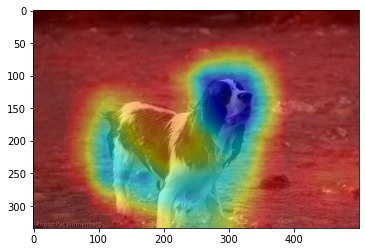

[('English springer, English springer spaniel', 29.19173538684845),
 ('Border collie', 6.204574927687645),
 ('Welsh springer spaniel', 4.611336812376976),
 ('cocker spaniel, English cocker spaniel, cocker', 1.7172673717141151),
 ('clumber, clumber spaniel', 1.3804375194013119)]

In [ ]:
#@title Visualising Pre-trained CNNs with GradCam (Generates new image every time)
from torchvision import models
model = models.resnet50(pretrained=True)
grad_cam = GradCam(model=model, feature_module=model.layer4, \
                    target_layer_names=["2"], use_cuda=torch.cuda.is_available())
model.eval()
k='./imagenette2'
k1=os.listdir(k)
k=k+'/'+k1[np.random.randint(len(k1))]
k1=os.listdir(k)
k=k+'/'+k1[np.random.randint(len(k1))]
k1=os.listdir(k)
k=k+'/'+k1[np.random.randint(len(k1))]

img = cv2.imread(k, 1)
img_original=img.copy()
plt.imshow(img)
img = np.float32(img) / 255
# Opencv loads as BGR:
img = img[:, :, ::-1]
input_img = preprocess_image(img)

target_category = None
grayscale_cam = grad_cam(input_img, target_category)

grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
cam = show_cam_on_image(img, grayscale_cam)

tens=model.to(dev)(input_img.to(dev))
out=torch.softmax(tens,dim=1)
_, indices = torch.sort(out, descending=True)
plt.imshow(cam)
plt.show()
[(dict_map[idx], 100*out[0][idx].item()) for idx in indices.cpu().numpy()[0][:5]]

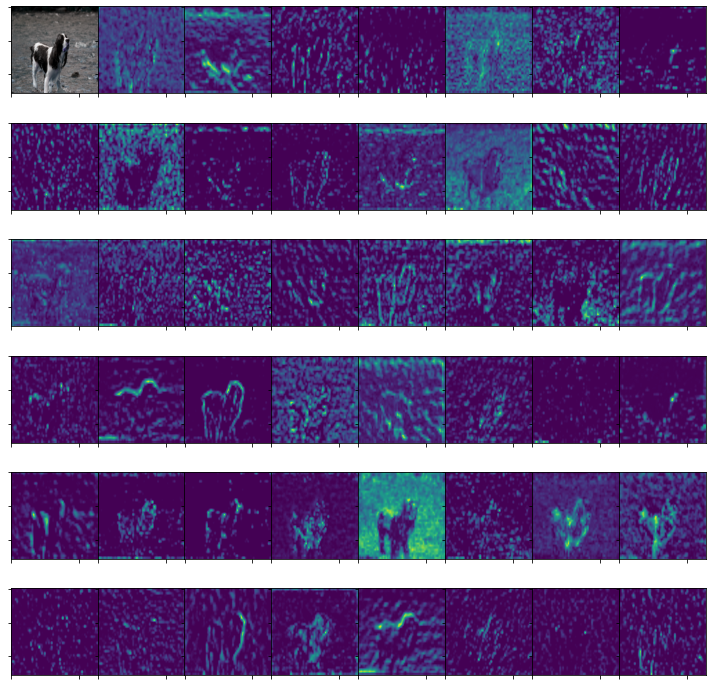

In [ ]:
#@title Visualisation V2.0 : What do the features look like ?
Layer_Name= 'layer2' #@param ["conv1", "layer1","layer2","layer3","layer4"]
Num_Filters = 48 #@param {type:"slider", min:8, max:64, step:8}
from skimage.transform import resize
import matplotlib.pyplot as plt
def temp_rem(model,key,input_img):
    model.eval()
    flag=0
    alt_=[]    
    for search in model._modules.keys():
        if flag==1:
            break
        if key==search:
            flag=1
        
        alt_.append(model._modules[search])

    return torch.nn.Sequential(*alt_).to(dev)(input_img.to(dev)).squeeze().detach().cpu().numpy()

def plot(data,Num_Filters,img_original):
    import matplotlib.pyplot as plt
    i=0
    flag=0
    if len(data)==3:
        fig, ax = plt.subplots(nrows=1, ncols=4)

        for col in ax:
            if flag==0:
                col.imshow(resize(img_original,(256,256)))    
                flag=1
            else:
                col.imshow(resize(data[i],(256,256)))
                i=i+1
        fig.set_size_inches(15,15)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    else:
        ncols=8
        nrows=Num_Filters//ncols
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
        for row in ax:
            for col in row:
                if flag==0:
                    col.imshow(resize(img_original,(256,256)))    
                    col.set_xticklabels([])
                    col.set_yticklabels([])
                    #col.set_aspect('equal')
                    flag=1
                else:
                    col.imshow(resize(data[i],(256,256)))
                    col.set_xticklabels([])
                    col.set_yticklabels([])
                    #col.set_aspect('equal')
                i=i+1
        
        
        fig.set_size_inches(10,10)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
    



#print("Named Blocks in ResNet50 {}".format(model._modules.keys()))
plot(temp_rem(model,Layer_Name,input_img),Num_Filters,img_original)
#print(temp_rem(model,Layer_Name,input_img).shape)
plt.show()


In [ ]:
#@title More Visualisation: An overview

from IPython.display import HTML
HTML('<iframe width="1020" height="660" src="https://poloclub.github.io/cnn-explainer/" allowfullscreen></iframe>')

# Redundant

In [ ]:
'''
Visualising output from Convs
'''
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import numpy as np
import cv2
from livelossplot import PlotLosses


    
def main():
    # Training settings
    num_workers=0
    use_cuda= torch.cuda.is_available()
    gamma=0.7
    save_model=True
    batch_size=64
    lr=0.01
    test_batch_size=64
    epochs=50


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    liveloss = PlotLosses()
    train_kwargs = {'num_workers':num_workers,'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'num_workers':num_workers,'batch_size': test_batch_size,'shuffle':True}
    
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    dataset_train = torchvision.datasets.CIFAR10(
            root='./', train=True, download=False, transform=transform_train)
    
    dataset_test = torchvision.datasets.CIFAR10(
            root='./', train=False, download=False, transform=transform_test)
    
    #dataset_train= TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels),transform=transform_train)
    #dataset_test= TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels),transform=transform_test)
    
    train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

    model = torchvision.models.resnet18().to(device)    
    model._modules['fc']=nn.Linear(512,10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001,nesterov=True,momentum=0.9)

    
    #scheduler = StepLR(optimizer, step_size=1,gamma=gamma)
    #logs={}
    for epoch in range(1, epochs + 1):
        print("Epoch {}".format(epoch))
        model.train()
        logs={}
        log_interval=10
        loss_sum=0.0
        ctr=0
        correct=0
        from tqdm.auto import tqdm
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target.long())
            loss.backward()
            loss_sum+=float(loss)/(len(train_loader.dataset)//data.shape[0])
            
            pred = torch.softmax(output,1).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            optimizer.step()
            ctr+=1
            #print(float(loss))
            
        print('Epoch {} Train loss {}'.format(epoch, loss_sum/ctr))
        

        model.eval()
        test_loss = 0
        correct = 0
        ctr=0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += nn.CrossEntropyLoss()(output, target.long()).item()  # sum up batch loss
                pred = torch.softmax(output,1).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                ctr+=1
                

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        torch.save(model.state_dict(), 'classifier_basic.pt')
        
        
        #scheduler.step()



if __name__ == '__main__':
    main()


Epoch 1



Epoch 1 Train loss 0.002244594495256274

Test set: Average loss: 0.0227, Accuracy: 4642/10000 (46%)

Epoch 2



Epoch 2 Train loss 0.0018509330782445657

Test set: Average loss: 0.0202, Accuracy: 5358/10000 (54%)

Epoch 3



Epoch 3 Train loss 0.0016696923087168645

Test set: Average loss: 0.0183, Accuracy: 5782/10000 (58%)

Epoch 4



Epoch 4 Train loss 0.0015367749034948253

Test set: Average loss: 0.0171, Accuracy: 6053/10000 (61%)

Epoch 5



Epoch 5 Train loss 0.0014424782566021279

Test set: Average loss: 0.0161, Accuracy: 6324/10000 (63%)

Epoch 6



Epoch 6 Train loss 0.0013590477308426613

Test set: Average loss: 0.0157, Accuracy: 6427/10000 (64%)

Epoch 7



Epoch 7 Train loss 0.0012918266458348743

Test set: Average loss: 0.0150, Accuracy: 6583/10000 (66%)

Epoch 8



Epoch 8 Train loss 0.0012390762574726634

Test set: Average loss: 0.0142, Accuracy: 6791/10000 (68%)

Epoch 9



Epoch 9 Train loss 0.0011946889408322775

Test set: Average loss: 0.0139, Accuracy: 6895/10000 (69%)

Epoch 10



Epoch 10 Train loss 0.0011450916028329684

Test set: Average loss: 0.0134, Accuracy: 6964/10000 (70%)

Epoch 11



Epoch 11 Train loss 0.0011162430694858054

Test set: Average loss: 0.0130, Accuracy: 7090/10000 (71%)

Epoch 12



Epoch 12 Train loss 0.0010824673058299123

Test set: Average loss: 0.0133, Accuracy: 7015/10000 (70%)

Epoch 13



Epoch 13 Train loss 0.0010542163970601274

Test set: Average loss: 0.0127, Accuracy: 7121/10000 (71%)

Epoch 14



Epoch 14 Train loss 0.0010284463866656374

Test set: Average loss: 0.0123, Accuracy: 7230/10000 (72%)

Epoch 15



Epoch 15 Train loss 0.000998423213021996

Test set: Average loss: 0.0122, Accuracy: 7280/10000 (73%)

Epoch 16



Epoch 16 Train loss 0.0009723659321812342

Test set: Average loss: 0.0122, Accuracy: 7273/10000 (73%)

Epoch 17



Epoch 17 Train loss 0.0009462431990550155

Test set: Average loss: 0.0119, Accuracy: 7315/10000 (73%)

Epoch 18



Epoch 18 Train loss 0.0009305264447280046

Test set: Average loss: 0.0116, Accuracy: 7461/10000 (75%)

Epoch 19



Epoch 19 Train loss 0.0009080112885739744

Test set: Average loss: 0.0118, Accuracy: 7374/10000 (74%)

Epoch 20



Epoch 20 Train loss 0.0008844739374830461

Test set: Average loss: 0.0117, Accuracy: 7397/10000 (74%)

Epoch 21



Epoch 21 Train loss 0.0008739020956088614

Test set: Average loss: 0.0115, Accuracy: 7462/10000 (75%)

Epoch 22



Epoch 22 Train loss 0.0008540792219897045

Test set: Average loss: 0.0113, Accuracy: 7474/10000 (75%)

Epoch 23



Epoch 23 Train loss 0.0008338101266651707

Test set: Average loss: 0.0112, Accuracy: 7508/10000 (75%)

Epoch 24



Epoch 24 Train loss 0.0008237024611423439

Test set: Average loss: 0.0111, Accuracy: 7511/10000 (75%)

Epoch 25



Epoch 25 Train loss 0.000805909462133106

Test set: Average loss: 0.0111, Accuracy: 7589/10000 (76%)

Epoch 26



Epoch 26 Train loss 0.0007894127497427453

Test set: Average loss: 0.0112, Accuracy: 7523/10000 (75%)

Epoch 27



Epoch 27 Train loss 0.0007775347736128351

Test set: Average loss: 0.0108, Accuracy: 7631/10000 (76%)

Epoch 28


In [ ]:
!rm -r data

In [ ]:
'''
Visualising output from Convs
'''
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import numpy as np
import cv2
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

def timeit(start):
    end=time.time()

    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)

def custom_after_subplot(ax: plt.Axes, group: str, x_label: str):
    """Make logarithmic scale on loss chart"""
    # if group == 'log-loss':
    #     ax.loglog()
    ax.set_xlabel("Iterations")
    ax.figure.set_size_inches(13, 5)
   



def main():
    # Training settings
    num_workers=0
    use_cuda= torch.cuda.is_available()
    gamma=0.7
    save_model=True
    batch_size=32
    lr=0.01
    test_batch_size=batch_size
    


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_kwargs = {'num_workers':num_workers,'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'num_workers':num_workers,'batch_size': test_batch_size,'shuffle':True}
    
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32,32)),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    dataset_train= TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))
    dataset_test= TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))
    
    train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

    model = torchvision.models.resnet152().to(device)    
    model = torchvision.models.vgg19_bn().to(device)    
    model._modules['classifier']._modules['6']=nn.Linear(4096,10).to(device)
    #model._modules['fc']=nn.Linear(2048,10).to(device)
    #model._modue

    optimizer = optim.SGD(model.parameters(), lr=0.01,nesterov=True,momentum=0.9)

    
    #scheduler = StepLR(optimizer, step_size=1,gamma=gamma)
    #logs={}
    generator_train = iter(train_loader)
    generator_val =iter(test_loader)
    logs={}
    outputs = [MatplotlibPlot(after_subplot=custom_after_subplot)]
    num_iters=1000
    groups={'Loss':['Training Loss','Validation Loss'],'Accuracy':['Training Accuracy','Validation Accuracy']}
    liveloss = PlotLosses(groups=groups,outputs=outputs)
    time_orig=time.time()
    
    #test_output(outputs)

    
    for epoch in range(num_iters):
        print("Iterations {} :: Time Elapsed {} :: ".format(epoch,timeit(time_orig)))
        model.train()
        
        log_interval=10
        loss_sum=0.0
        ctr=0
        correct=0

        

        try:
            # Samples the batch
            data, target = next(generator_train)
            data,target=data.to(device),target.to(device)
        except StopIteration:
            # restart the generator if the previous generator is exhausted.
            generator_train = iter(train_loader)
            data, target = next(generator_train)
            data,target=data.to(device),target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target.long())
        loss.backward()
        
        pred = torch.softmax(output,1).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct = (pred.eq(target.view_as(pred)).sum()/torch.numel(target))
        optimizer.step()
        ctr+=1
        log_loss=float(loss)
        log_corr=correct
        
        logs['Training Loss'] = log_loss
        logs['Training Accuracy'] = log_corr
    
        #print(loss_sum/ctr)
        del data,target
        
        with torch.no_grad():
        
            try:
                # Samples the batch
                data, target = next(generator_val)
                data,target=data.to(device),target.to(device)
            except StopIteration:
                # restart the generator if the previous generator is exhausted.
                generator_val = iter(test_loader)
                data, target = next(generator_val)
                data,target=data.to(device),target.to(device)
                    

            model.eval()
            test_loss = 0
            correct = 0
            ctr=0
            
            output = model(data)
            test_loss = nn.CrossEntropyLoss()(output, target.long()).item()  # sum up batch loss
            pred = torch.softmax(output,1).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = (pred.eq(target.view_as(pred)).sum()/torch.numel(target))
            ctr+=1
            log_loss=test_loss
            log_corr=float(correct)
            
        logs['Validation Loss'] = log_loss
        logs['Validation Accuracy'] = log_corr
        
        liveloss.update(logs)
        liveloss.send()      
        del data,target  
            


                
                
        torch.save(model.state_dict(), 'classifier_basic.pt')
        

        
    
        #scheduler.step()

if __name__ == '__main__':
    main()


In [ ]:
model = torchvision.models.resnet50().to(dev)    
model._modules['fc']=nn.Linear(2048,10).to(dev)
model.load_state_dict(torch.load('classifier_basic.pt'))
model.eval()
test_loss = 0
num_workers=0
test_batch_size=128
correct = 0
ctr=0
test_kwargs = {'num_workers':num_workers,'batch_size': test_batch_size,'shuffle':True}
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    #transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset_test= TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))
test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(dev), target.to(dev)
        

        output = model(data)
        test_loss += nn.CrossEntropyLoss()(output, target.long()).item()  # sum up batch loss
        pred = torch.softmax(output,1).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()/torch.numel(target)
        #print(pred.eq(target.view_as(pred)).sum().item()/torch.numel(target))
        ctr+=1
print("Accuracy on Test Set {}".format(correct/ctr))

Accuracy on Test Set 0.3638251582278481


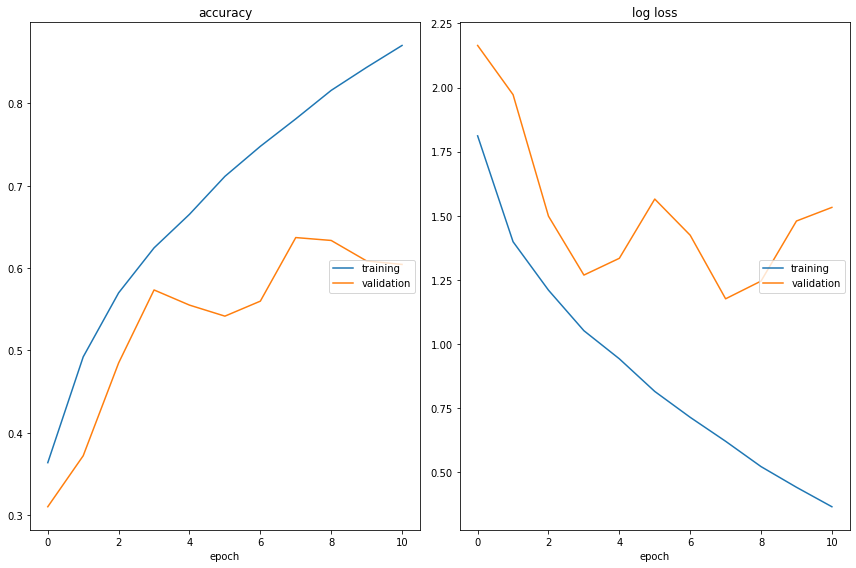

accuracy
	training         	 (min:    0.364, max:    0.870, cur:    0.870)
	validation       	 (min:    0.310, max:    0.637, cur:    0.604)
log loss
	training         	 (min:    0.366, max:    1.812, cur:    0.366)
	validation       	 (min:    1.176, max:    2.164, cur:    1.533)


KeyboardInterrupt: ignored

In [ ]:
def train_model(model, criterion, optimizer,dataloaders, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
                
                prefix = ''
                if phase == 'validation':
                    prefix = 'val_'

                logs[prefix + 'log loss'] = epoch_loss.item()
                logs[prefix + 'accuracy'] = epoch_acc.item()
            
            liveloss.update(logs)
            liveloss.send()

def splitter(dataset):
    length=len(dataset)
    return torch.utils.data.random_split(dataset,[int(length*0.3),(length-int(length*0.3))])

if __name__=='__main__':
    num_workers=0
    use_cuda= torch.cuda.is_available()
    gamma=0.7
    save_model=True
    batch_size=128
    lr=0.01
    test_batch_size=128
    epochs=50


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    liveloss = PlotLosses()
    train_kwargs = {'num_workers':num_workers,'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'num_workers':num_workers,'batch_size': test_batch_size,'shuffle':True}

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32,32)),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset_train,_= splitter(TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels)))
    
    dataset_test= TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

    train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

    model = torchvision.models.resnet18().to(device)

    torchvision.models.resnet18()._modules['fc']=nn.Linear(4096,10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)#,nesterov=True,momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    dataloaders={'train':train_loader,'validation':test_loader}
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    

    train_model(model, criterion, optimizer, dataloaders,num_epochs=20)



In [ ]:
!pip install livelossplot --quiet

In [ ]:
import torchvision
torchvision.models.vgg19_bn()._modules['classifier']._modules['6']=nn.Linear(4096,10)

In [ ]:
'''
Modules to add:

Invariance/Equivariance



Demonstrating need of 1x1 conv
3D Conv
Graph Conv
'''



In [ ]:
# @title Download CIFAR-10 and Load Data
%%capture
!rm -r /content/cifar-10-python.tar.gz
!rm -r /cifar-10-batches-py
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz
!rm -r /content/cifar-10-python.tar.gz

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
        load_cifar_10_data()


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [ ]:
#@title CIFAR-10 Data Exploration


from matplotlib.pyplot import figure

cifar_10_dir = 'cifar-10-batches-py'


print("Train data: ",train_data.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test labels: ", test_labels.shape)
print("Sample Images : ")
# display some random training images in a 25x25 grid
num_plot = 3

f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx].transpose(1,2,0))
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
        ax[m, n].set_title(label_names[train_labels[idx]].decode("utf-8"))
#f.subplots_adjust(hspace=0.1)
#f.subplots_adjust(wspace=0)
f.set_size_inches(2*num_plot, 2*num_plot)
plt.show()

del train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names


Train data:  (50000, 3, 32, 32)
Train labels:  (50000,)
Test data:  (10000, 3, 32, 32)
Test labels:  (10000,)
Sample Images : 


<IPython.core.display.Javascript object>